In [1]:
#default_exp metrics

First of all, let us get all the data that we need. Through the magic of `nbdev`, we will use the functionality we defined in `01_gettin_started`

In [2]:
from birdcall.data import *
from birdcall.metrics import *

import pandas as pd

In [3]:
classes = pd.read_pickle('data/classes.pkl')
train_ds = SpectrogramDataset(pd.read_pickle('data/train_set.pkl'), classes, len_mult=100, spec_max=80, spec_min=-100)
valid_ds = SpectrogramDataset(pd.read_pickle('data/val_set.pkl'), classes, len_mult=20)

In [4]:
len(train_ds), len(valid_ds)

(26400, 5280)

In [5]:
from fastai2.vision.all import *

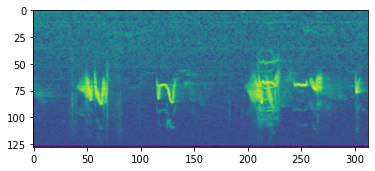

In [52]:
train_ds.show(0)

In [6]:
BS = 160

dls = DataLoaders(
    DataLoader(dataset=train_ds, bs=BS, num_workers=NUM_WORKERS, shuffle=True),
    DataLoader(dataset=valid_ds, bs=BS, num_workers=NUM_WORKERS)
).cuda()

In [7]:
b = dls.train.one_batch()
b[0].shape

torch.Size([160, 3, 128, 313])

In [8]:
b[0].mean(), b[0].std()

(tensor(-0.0297, device='cuda:0'), tensor(0.9990, device='cuda:0'))

In [9]:
get_arch = lambda: nn.Sequential(
    nn.Sequential(*list(resnet50(pretrained=True).children())[:6]),
    nn.Sequential(*list(resnet50(pretrained=True).children())[6:-2]),
    create_head(4096, 264),
    nn.Sigmoid()
)

A couple of functions to help us calculate metrics for diagnostics

In [10]:
def custom_splitter(model):
    return trainable_params(model[0]), trainable_params(model[1]), trainable_params(model[2])

In [11]:
learn = Learner(
    dls,
    get_arch(),
    metrics=[AccumMetric(precision), AccumMetric(recall), AccumMetric(f1)],
    loss_func=BCELossFlat(),
    splitter=custom_splitter
)

In [12]:
learn.freeze_to(-1)

In [13]:
learn.fit(5, 5e-2)

epoch,train_loss,valid_loss,precision,recall,f1,time
0,0.039903,0.132904,nan,0.000000,nan,01:24
1,0.028264,0.141792,0.004078,0.003788,0.003928,01:24
2,0.023393,1.001782,0.003815,0.034091,0.006862,01:24
3,0.021913,0.306348,0.003799,0.007576,0.005060,01:24
4,0.021307,0.160704,0.004724,0.003409,0.003960,01:24


In [14]:
learn.save('res50_train_head')

In [18]:
learn.unfreeze()

In [19]:
learn.fit_one_cycle(60, max_lr=(1e-4, 1e-3, 1e-2))

epoch,train_loss,valid_loss,precision,recall,f1,time
0,0.019782,0.314789,0.003617,0.007955,0.004972,01:27
1,0.019229,3.055514,0.003802,0.108523,0.007346,01:27
2,0.018837,2.871868,0.003861,0.104924,0.007449,01:27
3,0.018285,3.565467,0.003798,0.126894,0.007375,01:27
4,0.017763,0.814660,0.003764,0.029356,0.006673,01:27
5,0.017528,0.515471,0.003770,0.018939,0.006288,01:27
6,0.017023,0.396013,0.003781,0.014773,0.006021,01:27
7,0.016698,0.350531,0.003520,0.011742,0.005416,01:28
8,0.016064,4.977208,0.003688,0.201326,0.007244,01:28
9,0.015921,16.371050,0.003793,0.623295,0.007541,01:27


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [20]:
learn.save('res50')

In [21]:
learn.validate()

(#4) [1.2641615867614746,0.0035428632982075214,0.05000000074505806,0.0066168718327250615]

In [22]:
learn.fit_one_cycle(40, max_lr=(1e-5, 1e-4, 1e-3))

epoch,train_loss,valid_loss,precision,recall,f1,time
0,0.003618,22.212219,0.003797,0.816099,0.007558,01:28
1,0.003620,15.854492,0.003803,0.606250,0.007558,01:28
2,0.003753,0.145501,nan,0.000000,nan,01:27
3,0.004157,15.089296,0.003764,0.575379,0.007478,01:27
4,0.004669,0.170600,0.000000,0.000000,0.000000,01:28
5,0.005159,0.170389,nan,0.000000,nan,01:27
6,0.005557,0.165285,nan,0.000000,nan,01:28
7,0.006521,0.129963,nan,0.000000,nan,01:28
8,0.006259,0.170693,nan,0.000000,nan,01:28
9,0.006179,0.165785,nan,0.000000,nan,01:28


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [23]:
learn.save('res50_additional_training')

In [24]:
preds, targs = learn.get_preds()

In [25]:
preds.shape

torch.Size([5280, 264])

In [26]:
preds.max()

tensor(2.5885e-07)

tensor(0.)

In [32]:
preds, targs = learn.get_preds()

In [35]:
targs[1]

tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

In [49]:
preds

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [40]:
preds[3].argmax()

tensor(263)

This doesn't look great! Maybe we have a bug somewhere in the training, maybe our code for caclulating metrics is bugged. It might also be that it will be very hard to learn from raw audio or that our architecture and the task are mismatched.

I would guess the issue lies somwhere between training on raw audio and the architecture choice. Nonetheless, this will not stop us! The first order of business is to create an end to end pipeline, all the way to successful submission. Once we have this in place, we will be in a good position to start fiddling with making improvements.

In [14]:
mkdir data/models

In [15]:
torch.save(learn.model.state_dict(), 'data/models/first_model.pth')